# Import Library

In [91]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from surprise import accuracy

# Import Dataset

In [2]:
# Import dataset
df_books = pd.read_csv('Book_Dataset/Books.csv')
df_ratings = pd.read_csv('Book_Dataset/Ratings.csv')
df_users = pd.read_csv('Book_Dataset/Users.csv')

/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/377309377.py:2: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_books = pd.read_csv('Book_Dataset/Books.csv')


In [3]:
df_books.head()

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   

            Book-Author Year-Of-Publication                   Publisher  \
0    Mark P. O. Morford                2002     Oxford University Press   
1  Richard Bruce Wright                2001       HarperFlamingo Canada   
2          Carlo D'Este                1991             HarperPerennial   
3      Gina Bari Kolata                1999        Farrar Straus Giroux   
4       E. J. W. Barber                1999  W. W. Norton &amp; Company   

                                         Image-URL-S  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-M  \
0  http://images.amazon.com/images/P/0195153448.0...   
1  http://images.amazon.com/images/P/0002005018.0...   
2  http://images.amazon.com/images/P/0060973129.0...   
3  http://images.amazon.com/images/P/0374157065.0...   
4  http://images.amazon.com/images/P/0393045218.0...   

                                         Image-URL-L  
0  http://images.amazon.com/images/P/0195153448.0...  
1  http://images.amazon.com/images/P/0002005018.0...  
2  http://images.amazon.com/images/P/0060973129.0...  
3  http://images.amazon.com/images/P/0374157065.0...  
4  http://images.amazon.com/images/P/0393045218.0...

In [4]:
df_users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [ ]:
print(df_books.shape)
print(df_ratings.shape)
print(df_users.shape)

(271360, 8)
(1149780, 3)
(278858, 3)


Dataset tersebut memiliki ukuran yang berbeda-beda :
- df_books memiliki 271.360 dengan 8 kolom
- df_ratings memiliki 1.149.780 dengan 3 kolom
- df_users memiliki 278858 dengan 3 kolom

# Exploratory Data Analysis

Pada bagian ini kita akan melihat karakteristik dan bentuk data yang sudah kita import sebelumnya. Setelah dianalisa, kita bisa melakukan beberapa tahapan, seperti :
1. Menghilangkan `duplicated data`
2. Membuang `features` yang tidak penting (images pada df_books)
3. Mengatasi `Missing Values`
4. dan membandingkan `Unique Values`

In [6]:
# Menghapus data yang mengalami duplikasi
df_books = df_books.drop_duplicates()
df_ratings = df_ratings.drop_duplicates()
df_users = df_users.drop_duplicates()

## `df_books`

In [7]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


Pada df_books terdapat `features` yang kurang penting, seperti Image-URL-S/M/L. Hal ini tidak akan digunakan dalam sistem rekomendasi, lebih baik kita drop saja.

In [8]:
df_books_dropped = df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'], axis=1)
df_books_dropped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
dtypes: object(5)
memory usage: 10.4+ MB


Terdapat data yang hilang sehingga kita dapat menghilangkan **missing values** pada `Book-Author` dan `Publisher` karena jumlah dataset yang masih terlampau banyak sehingga penghapusan beberapa data kosong tidak akan mempengaruhui data kita.

In [9]:
df_books_dropped[df_books_dropped.isnull().any(axis=1)]

ISBN                                         Book-Title  \
118033  0751352497                           A+ Quiz Masters:01 Earth   
128890  193169656X                                        Tyrant Moon   
129037  1931696993                                    Finders Keepers   
187689  9627982032  The Credit Suisse Guide to Managing Your Perso...   

            Book-Author Year-Of-Publication                       Publisher  
118033              NaN                1999              Dorling Kindersley  
128890  Elaine Corvidae                2002                             NaN  
129037  Linnea Sinclair                2001                             NaN  
187689              NaN                1995  Edinburgh Financial Publishing

In [10]:
df_books_nan = df_books_dropped.dropna()
df_books_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271356 non-null  object
 1   Book-Title           271356 non-null  object
 2   Book-Author          271356 non-null  object
 3   Year-Of-Publication  271356 non-null  object
 4   Publisher            271356 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB


In [11]:
df_books_nan.head(10)

ISBN                                         Book-Title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   
5  0399135782                             The Kitchen God's Wife   
6  0425176428  What If?: The World's Foremost Military Histor...   
7  0671870432                                    PLEADING GUILTY   
8  0679425608  Under the Black Flag: The Romance and the Real...   
9  074322678X            Where You'll Find Me: And Other Stories   

            Book-Author Year-Of-Publication                   Publisher  
0    Mark P. O. Morford                2002     Oxford University Press  
1  Richard Bruce Wright                2001       HarperFlamingo Canada  
2          Carlo D'Este                1991             HarperPerennial  
3      Gina Bari Kolata                1999        Farrar Straus Giroux  
4       E. J. W. Barber                1999  W. W. Norton &amp; Company  
5               Amy Tan                1991            Putnam Pub Group  
6         Robert Cowley                2000    Berkley Publishing Group  
7           Scott Turow                1993                  Audioworks  
8       David Cordingly                1996                Random House  
9           Ann Beattie                2002                    Scribner

Kita perlu mengubah bentuk judul `features` **Book-Title**, **Book-Author**, dan **Year-Of-Publication** pada dataframe agar lebih mudah dilihat

In [12]:
df_books_renamed = df_books_nan.rename(columns={'Book-Title':'book_title','Book-Author':'book_author','Year-Of-Publication':'YoP'})
df_books_renamed.head(10)

ISBN                                         book_title  \
0  0195153448                                Classical Mythology   
1  0002005018                                       Clara Callan   
2  0060973129                               Decision in Normandy   
3  0374157065  Flu: The Story of the Great Influenza Pandemic...   
4  0393045218                             The Mummies of Urumchi   
5  0399135782                             The Kitchen God's Wife   
6  0425176428  What If?: The World's Foremost Military Histor...   
7  0671870432                                    PLEADING GUILTY   
8  0679425608  Under the Black Flag: The Romance and the Real...   
9  074322678X            Where You'll Find Me: And Other Stories   

            book_author   YoP                   Publisher  
0    Mark P. O. Morford  2002     Oxford University Press  
1  Richard Bruce Wright  2001       HarperFlamingo Canada  
2          Carlo D'Este  1991             HarperPerennial  
3      Gina Bari Kolata  1999        Farrar Straus Giroux  
4       E. J. W. Barber  1999  W. W. Norton &amp; Company  
5               Amy Tan  1991            Putnam Pub Group  
6         Robert Cowley  2000    Berkley Publishing Group  
7           Scott Turow  1993                  Audioworks  
8       David Cordingly  1996                Random House  
9           Ann Beattie  2002                    Scribner

In [13]:
print('Jumlah data ISBN: ', len(df_books_renamed.ISBN.unique()))
print('Jumlah data Judul Buku: ', len(df_books_renamed.book_title.unique()))
print('Jumlah data Penulis Buku: ', len(df_books_renamed.book_author.unique()))
print('Jumlah data Tahun Terbit Buku ', len(df_books_renamed.YoP.unique()))

Jumlah data ISBN:  271356
Jumlah data Judul Buku:  242132
Jumlah data Penulis Buku:  102021
Jumlah data Tahun Terbit Buku  202


In [14]:
df_books_renamed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ISBN         271356 non-null  object
 1   book_title   271356 non-null  object
 2   book_author  271356 non-null  object
 3   YoP          271356 non-null  object
 4   Publisher    271356 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB


In [15]:
# Hitung kemunculan setiap book_title
title_counts = df_books_renamed['book_title'].value_counts()

# Tampilkan hanya yang muncul lebih dari 1 kali
duplicated_titles = title_counts[title_counts > 1]
print(duplicated_titles)


book_title
Selected Poems                                     27
Little Women                                       24
Wuthering Heights                                  21
Adventures of Huckleberry Finn                     20
The Secret Garden                                  20
                                                   ..
Deus Irae                                           2
SPQR II: The Catiline Conspiracy                    2
What to Expect the First Year                       2
Next: The Future Just Happened                      2
Bleeding Maize and Blue (Anneke Haagen Mystery)     2
Name: count, Length: 19907, dtype: int64


In [16]:
df_books_renamed.query('book_title == "Selected Poems"')

ISBN      book_title                 book_author   YoP  \
4523    081120958X  Selected Poems     William Carlos Williams  1985   
39416   0811201465  Selected Poems                  K. Patchen  1957   
41316   0679750800  Selected Poems                   Rita Dove  1993   
106885  0060931744  Selected Poems            Gwendolyn Brooks  1999   
118775  0517101548  Selected Poems                  John Donne  1994   
127462  0520012984  Selected Poems               Paul Verlaine  1970   
156894  0871401541  Selected Poems              E. E. Cummings  1994   
158312  0060909897  Selected Poems            Gwendolyn Brooks  1963   
175602  0571050190  Selected Poems         T.           T Gunn  1962   
183908  1550651498  Selected Poems             Ralph Gustafson  2001   
184897  0333516265  Selected Poems                Thomas Hardy  1989   
189247  0679430830  Selected Poems                   Rita Dove  1993   
189963  0940262193  Selected Poems              Kathleen Raine  1989   
196944  0802151027  Selected Poems                Pablo Neruda  1961   
198960  1852240954  Selected Poems                Jenny Joseph  1992   
202448  0679765654  Selected Poems              Daniel Halpern  1996   
202743  0906427851  Selected Poems             Denise Levertov  1986   
213189  0520069358  Selected Poems              Robert Creeley  1991   
215269  0156003961  Selected Poems               Carl Sandburg  1996   
226024  0395320461  Selected Poems              Galway Kinnell  1983   
232061  006093168X  Selected Poems     Edna St. Vincent Millay  1999   
236707  0679724834  Selected Poems                 W. H. Auden  1989   
247784  0394702956  Selected Poems                  R. Jeffers  1963   
248309  0811209512  Selected Poems            Michael Mc Clure  1986   
248837  0670809179  Selected Poems                John Ashbery  1985   
251692  0460871501  Selected Poems  Elizabeth Barrett Browning  1992   
254097  0571210767  Selected Poems              Simon Armitage  2001   

                                    Publisher  
4523    New Directions Publishing Corporation  
39416   New Directions Publishing Corporation  
41316                       Vintage Books USA  
106885                              Perennial  
118775                         Gramercy Books  
127462         University of California Press  
156894       Liveright Publishing Corporation  
158312                          Harpercollins  
175602             Farrar Straus &amp; Giroux  
183908                         Vehicule Press  
184897                              Macmillan  
189247                         Pantheon Books  
189963                     Rudolph Steiner Pr  
196944                            Grove Press  
198960                     Bloodaxe Books Ltd  
202448                        Alfred A. Knopf  
202743                     Bloodaxe Books Ltd  
213189         University of California Press  
215269                          Harvest Books  
226024               Houghton Mifflin Company  
232061                              Perennial  
236707                      Vintage Books USA  
247784                      Vintage Books USA  
248309                W W Norton &amp; Co Inc  
248837                            Penguin USA  
251692               Phoenix mass market p/bk  
254097                    Faber and Faber Ltd

In [17]:
# Pertama kita group berdasarkan 'book_title'
grouped = df_books_renamed.groupby('book_title')

# Lalu kita cek berapa banyak ISBN unik untuk setiap book_title
isbn_check = grouped['ISBN'].nunique()

# Tampilkan book_title yang hanya punya 1 ISBN unik
same_isbn = isbn_check[isbn_check == 1]
print("Book titles dengan 1 ISBN:")
same_isbn.count()

Book titles dengan 1 ISBN:


222225

In [18]:
# Tampilkan book_title yang punya lebih dari 1 ISBN unik
different_isbn = isbn_check[isbn_check > 1]
print("\nBook titles dengan ISBN yang berbeda:")
different_isbn.head()


Book titles dengan ISBN yang berbeda:


book_title
!%@ (A Nutshell handbook)                                             2
'A Hell of a Place to Lose a Cow': An American Hitchhiking Odyssey    2
'Salem's Lot                                                          3
...And Now Miguel                                                     2
1,003 Great Things About Teachers                                     2
Name: ISBN, dtype: int64

In [19]:
# Melihat detail ISBN untuk setiap book_title
isbn_details = grouped['ISBN'].unique()

# Menampilkan book_title dengan lebih dari 1 ISBN
isbn_details = isbn_details[isbn_details.apply(lambda x: len(x) > 1)]
print("\nDetail ISBN untuk book_title yang sama:")
isbn_details.head(10)


Detail ISBN untuk book_title yang sama:


book_title
!%@ (A Nutshell handbook)                                                         [1565920465, 1565920317]
'A Hell of a Place to Lose a Cow': An American Hitchhiking Odyssey                [0792276833, 0792277295]
'Salem's Lot                                                          [0451168089, 067103975X, 0385007515]
...And Now Miguel                                                                 [0690091184, 006440143X]
1,003 Great Things About Teachers                                                 [1567315070, 0740709895]
10 Lb. Penalty                                                                    [0399143025, 0515123471]
10,000 Garden Questions Answered by 20 Experts                                    [0385004796, 051712226X]
10,000 dreams interpreted: A dictionary of dreams                                 [1566196256, 1566196264]
100 Dastardly Little Detective Stories                                            [1566199204, 1566191076]
100 Hair Raising Little Ho

In [20]:
df_books_renamed[df_books_renamed['book_title'] == '!%@ (A Nutshell handbook)']

ISBN                 book_title    book_author   YoP Publisher
75637   1565920465  !%@ (A Nutshell handbook)  Donnalyn Frey  1994  O'Reilly
156341  1565920317  !%@ (A Nutshell handbook)  Donnalyn Frey  1993  O'Reilly

In [21]:
df_books_renamed[df_books_renamed['book_title'] == "'Salem's Lot"]

ISBN    book_title   book_author   YoP        Publisher
10438  0451168089  'Salem's Lot  Stephen King  1990      Signet Book
22024  067103975X  'Salem's Lot  Stephen King  2000           Pocket
94187  0385007515  'Salem's Lot  Stephen King  1993  Doubleday Books

Ternyata tidak terdapat duplicated data karena ISBN berbeda, penulis berbeda, tahun berbeda, dan publisher yang berbeda tidak dikategorikan sebagai duplicated data. Buku dengan judul yang sama tetapi dutulis oleh orang yang berbeda sudah pasti memiliki isi yang berbeda, begitu juga dengan tahun terbit yang berbeda, tetapi untuk ISBN yang sama maka itu perlu diinvestigasi lebih lanjut

## `df_ratings`

In [22]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


tidak terdapat missing values. Sekarang mari kita lihat apakah terdapat duplicated values, tetapi kita perlu mengganti judul dari kolom agar tidak terjadi error ketika melihat unique values

In [23]:
df_ratings_renamed = df_ratings.rename(columns={'User-ID':'user_id', 'Book-Rating':'book_rating'})
df_ratings_renamed.head()

user_id        ISBN  book_rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

In [24]:
print('Jumlah unique value user ID: ', len(df_ratings_renamed.user_id.unique()))
print('Jumlah unique value ISBN: ', len(df_ratings_renamed.ISBN.unique()))
print('Jumlah unique value Rating: ', len(df_ratings_renamed.book_rating.unique()))

Jumlah unique value user ID:  105283
Jumlah unique value ISBN:  340556
Jumlah unique value Rating:  11


In [ ]:
df_ratings_renamed.shape

(1149780, 3)

Terlihat bahwa dari data 1.149.780, ternyata hanya ada 105.283 ID. Akan tetapi, ISBN hanya 340.556? Mari kita lihat lebih lanjut. Terdapat 2 kemungkinan :
1. User yang sama memberikan rating ke beberapa buku atau beberapa user memberikan rating ke satu buku yang sama
2. User melakukan rating ke buku yang sama lebih dari sekali dan disimpan berulang. 

In [26]:
# Cek apakah ada baris yang persis sama (semua kolom user_id, ISBN, rating)
duplicated_rows = df_ratings_renamed.duplicated()

# Berapa banyak duplicated rows?
print("Jumlah duplicated baris:", duplicated_rows.sum())

Jumlah duplicated baris: 0


In [27]:
# Cek duplikat berdasarkan kombinasi user_id dan ISBN saja
duplicated_user_isbn = df_ratings_renamed.duplicated(subset=['user_id', 'ISBN'])

print("Jumlah duplicated berdasarkan (user_id, ISBN):", duplicated_user_isbn.sum())

Jumlah duplicated berdasarkan (user_id, ISBN): 0


Ternyata data ini cukup bersih :
1. Tidak ada `missing values`
2. Tidak ada `duplicated data`
3. Tidak ada features yang tidak penting

## `df_users`

In [28]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [29]:
df_users.isnull().sum()

User-ID          0
Location         0
Age         110762
dtype: int64

Terdapat missing values pada data Age

In [30]:
df_users[df_users.isnull().any(axis=1)]

User-ID                            Location  Age
0             1                  nyc, new york, usa  NaN
2             3     moscow, yukon territory, russia  NaN
4             5  farnborough, hants, united kingdom  NaN
6             7                 washington, dc, usa  NaN
7             8            timmins, ontario, canada  NaN
...         ...                                 ...  ...
278849   278850          sergnano, lombardia, italy  NaN
278853   278854               portland, oregon, usa  NaN
278855   278856           brampton, ontario, canada  NaN
278856   278857           knoxville, tennessee, usa  NaN
278857   278858                dublin, n/a, ireland  NaN

[110762 rows x 3 columns]

Karena jumlah data umur yang memiliki NaN values sangat banyak, alangkah baiknya kita mengisinya terlebih dahulu dengan metode Group-by Location dimana kita mengisi NaN values semirip mungkin dengan data aslinya agar sistem rekomendasi dapat berjalan akurat. Kemudian usia orang di satu lokasi biasanya mirip-mirip.

In [31]:
for loc in df_users['Location'].unique():
    print(loc)


nyc, new york, usa
stockton, california, usa
moscow, yukon territory, russia
porto, v.n.gaia, portugal
farnborough, hants, united kingdom
santa monica, california, usa
washington, dc, usa
timmins, ontario, canada
germantown, tennessee, usa
albacete, wisconsin, spain
melbourne, victoria, australia
fort bragg, california, usa
barcelona, barcelona, spain
mediapolis, iowa, usa
calgary, alberta, canada
albuquerque, new mexico, usa
chesapeake, virginia, usa
rio de janeiro, rio de janeiro, brazil
weston, ,
langhorne, pennsylvania, usa
ferrol / spain, alabama, spain
erfurt, thueringen, germany
philadelphia, pennsylvania, usa
cologne, nrw, germany
oakland, california, usa
bellevue, washington, usa
chicago, illinois, usa
freiburg, baden-wuerttemberg, germany
cuernavaca, alabama, mexico
anchorage, alaska, usa
shanghai, n/a, china
portland, oregon, usa
costa mesa, california, usa
london, england, united kingdom
grafton, wisconsin, usa
montreal, quebec, canada
san sebastian, n/a, spain
viterbo, laz

Kita menemukan masalah lain, terdapat data lokasi yang sama tetapi memiliki struktur yang berbeda, seperti USA/US/United States of America/United States/United Stated/United Staes. Kemudian terdapat lokasi detail yang sepertinya tidak terlalu berpengaruh signifikan dan justru memberikan data jadi kotor dan terlalu variatif

In [32]:
df_users_modified = df_users
df_users_modified['Location'] = df_users_modified['Location'].apply(lambda x: ', '.join(x.split(', ')[3:]) 
                                                  if len(x.split(', ')) > 3 
                                                  else x)

df_users_modified.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

Sepertinya masih terdapat lokasi yang tidak diisi dengan benar dan kita harus mevalidasi lokasi tersebut berdasarkan negara yang ada. Kita akan menggunakan library pycountry untuk memudahkan kita melihat negara mana saja yang ada dan melihat daata mana saja yang bisa diperbaiki lokasinya.

In [33]:
global_median = df_users['Age'].median()

df_users['Age'] = df_users.groupby('Location')['Age'].transform(
    lambda x: x.fillna(x.median())
)

df_users['Age'].fillna(global_median, inplace=True)

print("Sisa NaN di Age: ", df_users["Age"].isna().sum())

/opt/anaconda3/envs/DL/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/DL/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/DL/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/DL/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/DL/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/opt/anaconda3/envs/DL/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
 

Sisa NaN di Age:  0


/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/4038639703.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_users['Age'].fillna(global_median, inplace=True)


Melihat bentuk data yang diisi tidak seragam lebih baik feature Location tidak perlu digunakan dalam sistem rekomendasi

In [34]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       278858 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [35]:
df_users_renamed = df_users.rename(columns={"User-ID":"user_id"})
df_users_renamed.head()

user_id                            Location   Age
0        1                  nyc, new york, usa  27.0
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia  55.0
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom  32.0

In [36]:
print('Jumlah unique value user ID: ', len(df_users_renamed.user_id.unique()))
print('Jumlah unique value Lokasi: ', len(df_users_renamed.Location.unique()))
print('Jumlah unique value Rating: ', len(df_users_renamed.Age.unique()))

Jumlah unique value user ID:  278858
Jumlah unique value Lokasi:  56527
Jumlah unique value Rating:  226


## Top 10 Most Rated Books

Melakukan analisa dan visualisasi terhadap buku-buku yang paling sering diulas oleh users

In [37]:
most_rated_books = df_ratings_renamed.groupby('ISBN')["book_rating"].count().sort_values(ascending=False).head(10)
most_rated_books = pd.DataFrame(most_rated_books)
most_rated_books

book_rating
ISBN                   
0971880107         2502
0316666343         1295
0385504209          883
0060928336          732
0312195516          723
044023722X          647
0679781587          639
0142001740          615
067976402X          614
0671027360          586

/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/4006704260.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = most_rated_books.values, y = most_rated_books.index, palette='coolwarm')


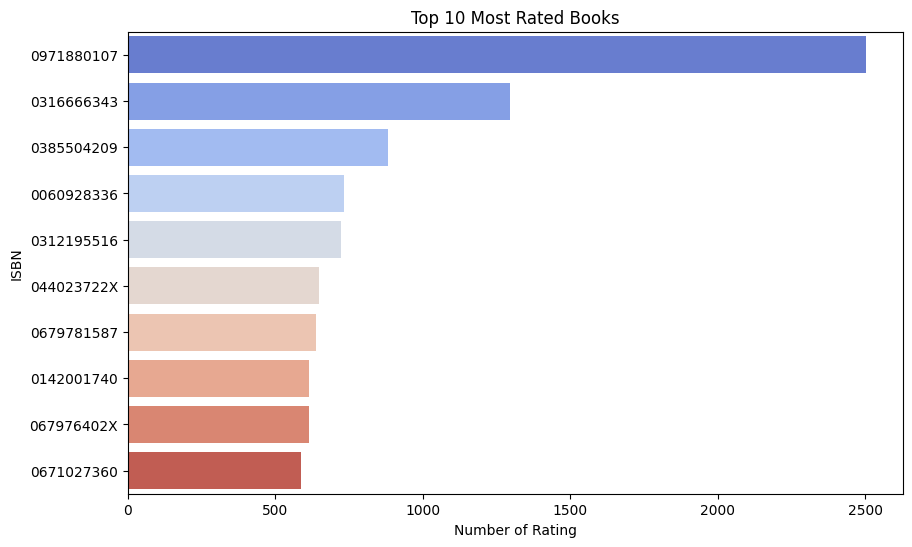

In [38]:
most_rated_books = df_ratings_renamed["ISBN"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x = most_rated_books.values, y = most_rated_books.index, palette='coolwarm')
plt.title("Top 10 Most Rated Books")
plt.xlabel("Number of Rating")
plt.ylabel("ISBN")
plt.show()

## Top 10 Prolific Authors

Melihat 10 penulis paling produktif

/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/4034018709.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_authors.values, y=top_authors.index, palette='coolwarm')


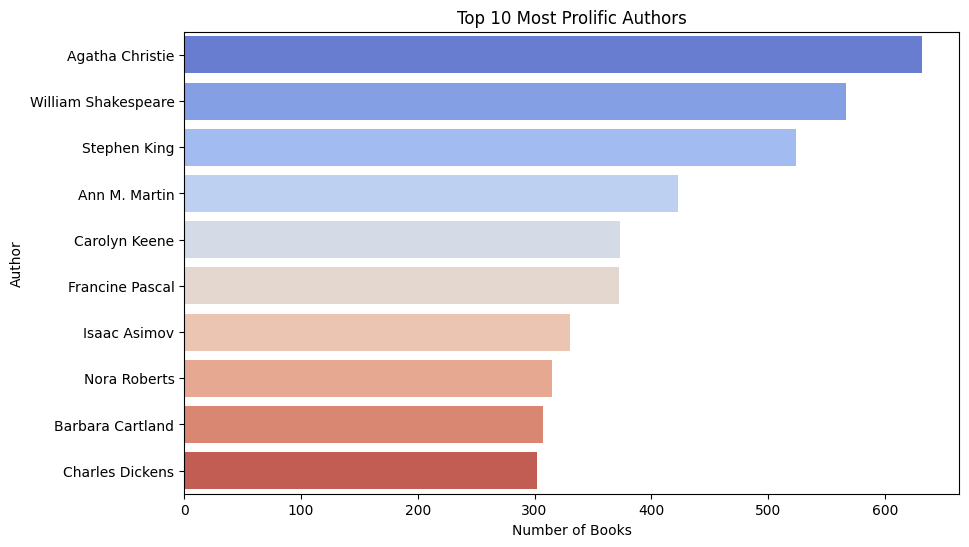

In [39]:

top_authors = df_books_renamed["book_author"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='coolwarm')
plt.title("Top 10 Most Prolific Authors")
plt.xlabel("Number of Books")
plt.ylabel("Author")
plt.show()

## Top 10 Publisher

Melihat 10 Publisher paling produktif mempublish

/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/3819288337.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_publisher.values, y=top_publisher.index, palette='coolwarm')


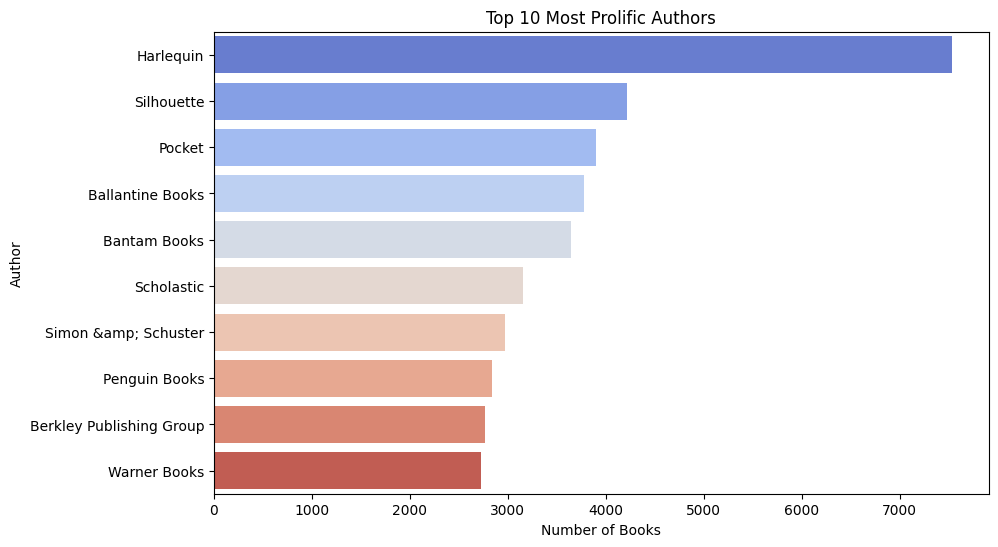

In [40]:
top_publisher = df_books_renamed["Publisher"].value_counts().head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=top_publisher.values, y=top_publisher.index, palette='coolwarm')
plt.title("Top 10 Most Prolific Authors")
plt.xlabel("Number of Books")
plt.ylabel("Author")
plt.show()

## Distribution of Year of Publication

Melihat distribusi terbitan buku berdasarkan tahun terbit

In [41]:
df_books_renamed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 271356 entries, 0 to 271359
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   ISBN         271356 non-null  object
 1   book_title   271356 non-null  object
 2   book_author  271356 non-null  object
 3   YoP          271356 non-null  object
 4   Publisher    271356 non-null  object
dtypes: object(5)
memory usage: 12.4+ MB


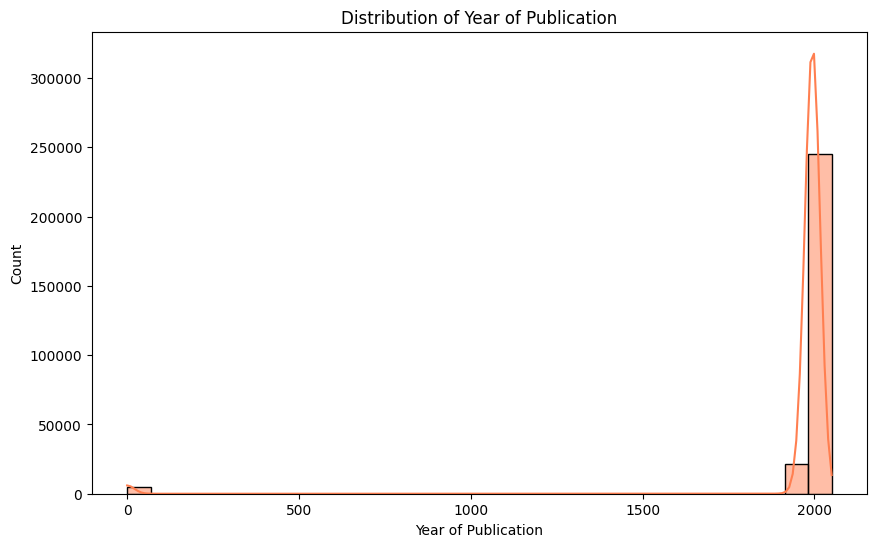

In [42]:
# Convert Year-Of-Publication to numeric (if not already) and handle errors
df_books_renamed['YoP'] = pd.to_numeric(df_books_renamed['YoP'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.histplot(df_books_renamed['YoP'].dropna(), bins=30, kde=True, color='coral')
plt.title("Distribution of Year of Publication")
plt.xlabel("Year of Publication")
plt.ylabel("Count")
plt.show()

In [43]:
df_books_renamed[df_books_renamed['YoP'] < 1900].count()

ISBN           4622
book_title     4622
book_author    4622
YoP            4622
Publisher      4622
dtype: int64

Ternyata terdapat tahun yang tidak ada alias bernilai 0. Terdapat 4622, karena jumlahnya tidak terlalu besar, kita hapus saja.

In [44]:
df_books_cleaned = df_books_renamed[df_books_renamed['YoP'] >= 1900]
df_books_cleaned[df_books_cleaned['YoP'] < 1900].count()

ISBN           0
book_title     0
book_author    0
YoP            0
Publisher      0
dtype: int64

/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/3415826868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_books_cleaned['YoP'] = pd.to_numeric(df_books_cleaned['YoP'], errors='coerce')


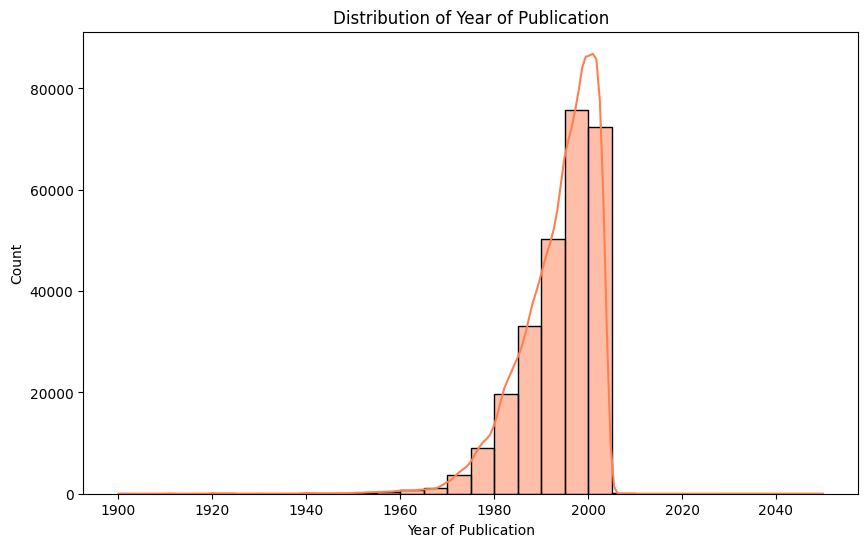

In [45]:
# Convert Year-Of-Publication to numeric (if not already) and handle errors
df_books_cleaned['YoP'] = pd.to_numeric(df_books_cleaned['YoP'], errors='coerce')

plt.figure(figsize=(10, 6))
sns.histplot(df_books_cleaned['YoP'].dropna(), bins=30, kde=True, color='coral')
plt.title("Distribution of Year of Publication")
plt.xlabel("Year of Publication")
plt.ylabel("Count")
plt.show()

Mayoritas tahun terbitan buku ada pada rentang 1990an - 2000an

## Distribution of Book Ratings

<Axes: >

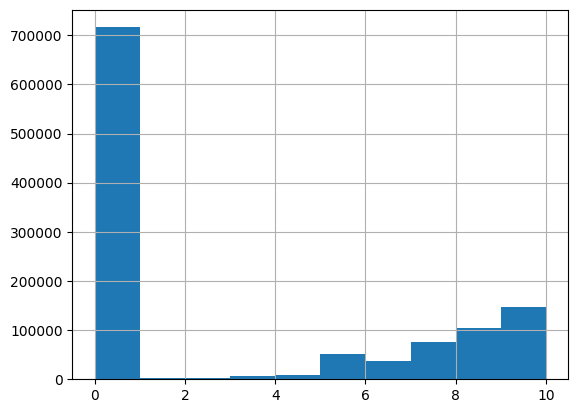

In [46]:
df_ratings_renamed["book_rating"].hist(bins=10)

In [47]:
df_ratings_cek = df_ratings_renamed[df_ratings_renamed.book_rating != 0]
df_ratings_cek.count()

user_id        433671
ISBN           433671
book_rating    433671
dtype: int64

Terdapat data rating yang bernilai 0. Hal ini bukan berarti buku tersebut dinilai jelek, tetapi terkadang karakteristik user lupa untuk memberi ulasan sehingga default value dari rating akan menghasilkan nilai 0.

<Axes: >

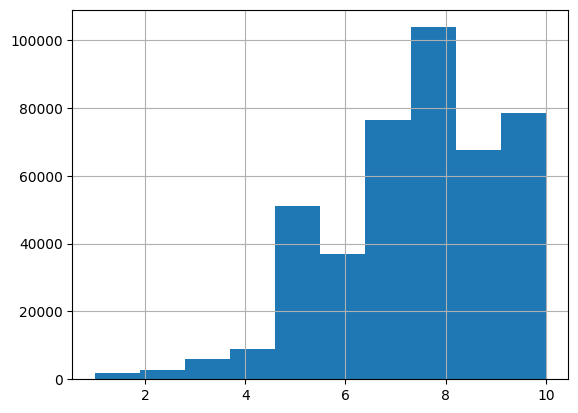

In [48]:
df_ratings_renamed = df_ratings_renamed.drop(df_ratings_renamed[df_ratings_renamed.book_rating == 0].index)
df_ratings_renamed["book_rating"].hist(bins=10)

# Data Preprocessing

karena jumlah datanya mencapai 1 juta yang mengakibatkan terpenuhnya memori, maka sampling dilakukan pada 10.000 data pertama saja untuk book_dataset dan 5000 untuk rating_dataset

In [49]:
book_dataset = df_books_renamed[:10000]
rating_dataset = df_ratings_renamed[:10000]

In [50]:
book_dataset.head(3)

ISBN            book_title           book_author     YoP  \
0  0195153448   Classical Mythology    Mark P. O. Morford  2002.0   
1  0002005018          Clara Callan  Richard Bruce Wright  2001.0   
2  0060973129  Decision in Normandy          Carlo D'Este  1991.0   

                 Publisher  
0  Oxford University Press  
1    HarperFlamingo Canada  
2          HarperPerennial

In [51]:
rating_dataset.head(3)

user_id        ISBN  book_rating
1   276726  0155061224            5
3   276729  052165615X            3
4   276729  0521795028            6

In [52]:
all_df = pd.merge(book_dataset, rating_dataset[['ISBN']], on='ISBN', how='left')
all_df

ISBN                                         book_title  \
0      0195153448                                Classical Mythology   
1      0002005018                                       Clara Callan   
2      0060973129                               Decision in Normandy   
3      0374157065  Flu: The Story of the Great Influenza Pandemic...   
4      0393045218                             The Mummies of Urumchi   
...           ...                                                ...   
11084  0380730774  Read This and Tell Me What It Says : Stories (...   
11085  0862418879                                     The Star Rover   
11086  340414645X                                   Die Keltennadel.   
11087  3442730988                                Tod in der Datscha.   
11088  3404144783                                            Dunkel.   

                book_author     YoP                   Publisher  
0        Mark P. O. Morford  2002.0     Oxford University Press  
1      Richard Bruce Wright  2001.0       HarperFlamingo Canada  
2              Carlo D'Este  1991.0             HarperPerennial  
3          Gina Bari Kolata  1999.0        Farrar Straus Giroux  
4           E. J. W. Barber  1999.0  W. W. Norton &amp; Company  
...                     ...     ...                         ...  
11084      A. Manette Ansay  1998.0              William Morrow  
11085           Jack London  2000.0             Canongate Books  
11086         Patrick Dunne  2001.0                    LÃ?Â¼bbe  
11087       Anna Malyschewa  2003.0                         btb  
11088     Wolfgang Hohlbein  2001.0                    LÃ?Â¼bbe  

[11089 rows x 5 columns]

In [53]:
book_ISBN = all_df['ISBN'].tolist()

book_title = all_df['book_title'].tolist()

book_author = all_df['book_author'].tolist()

book_year_of_publication = all_df['YoP'].tolist()

In [54]:
book = pd.DataFrame({
    'book_ISBN': book_ISBN,
    'book_title': book_title,
    'book_author': book_author,
    'book_year_of_publication': book_year_of_publication
})
book

book_ISBN                                         book_title  \
0      0195153448                                Classical Mythology   
1      0002005018                                       Clara Callan   
2      0060973129                               Decision in Normandy   
3      0374157065  Flu: The Story of the Great Influenza Pandemic...   
4      0393045218                             The Mummies of Urumchi   
...           ...                                                ...   
11084  0380730774  Read This and Tell Me What It Says : Stories (...   
11085  0862418879                                     The Star Rover   
11086  340414645X                                   Die Keltennadel.   
11087  3442730988                                Tod in der Datscha.   
11088  3404144783                                            Dunkel.   

                book_author  book_year_of_publication  
0        Mark P. O. Morford                    2002.0  
1      Richard Bruce Wright                    2001.0  
2              Carlo D'Este                    1991.0  
3          Gina Bari Kolata                    1999.0  
4           E. J. W. Barber                    1999.0  
...                     ...                       ...  
11084      A. Manette Ansay                    1998.0  
11085           Jack London                    2000.0  
11086         Patrick Dunne                    2001.0  
11087       Anna Malyschewa                    2003.0  
11088     Wolfgang Hohlbein                    2001.0  

[11089 rows x 4 columns]

# Model Development dengan Content Based Filtering
Content based filtering menggunakan kesamaan konten atau produk yang ada dengan kesamaan item dengan preferensi pengguna. Pada kasus kita kali ini kita menggunakan TF-IDF untuk membangun sistem rekomendasi berdasarkan penulis buku.

## TF-IDF Vectorizer

In [55]:
tf = TfidfVectorizer()
 
tf.fit(book['book_author']) 
 
tf.get_feature_names_out() 

array(['aaron', 'aarsen', 'abbey', ..., 'âºlveda', 'â¼ltner', 'â¼skind'],
      dtype=object)

In [56]:
tfidf_matrix = tf.fit_transform(book['book_author']) 
 
tfidf_matrix.shape 

(11089, 5575)

In [57]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [58]:
pd.DataFrame(
    tfidf_matrix.todense(), 
    columns=tf.get_feature_names_out(),
    index=book.book_title
).sample(10, axis=1,replace=True).sample(10, axis=0)

malyschewa  lawhead  whitley  \
book_title                                                                
American Chica: Two Worlds, One Childhood         0.0      0.0      0.0   
Fanny und Pepsi. ( Ab 12 J.).                     0.0      0.0      0.0   
The Second Coming of Curly Red                    0.0      0.0      0.0   
LA Tabla De Flandes                               0.0      0.0      0.0   
Shot in the Heart                                 0.0      0.0      0.0   
Callahan's Lady                                   0.0      0.0      0.0   
Dark Cathedral (Creed S.)                         0.0      0.0      0.0   
Die ZuckerbÃ?Â¤ckerin.                            0.0      0.0      0.0   
The Door into Summer                              0.0      0.0      0.0   
Dark Mirror, Dark Dreams                          0.0      0.0      0.0   

                                           cosby  leman  xinran  marciano  \
book_title                                                                  
American Chica: Two Worlds, One Childhood    0.0    0.0     0.0       0.0   
Fanny und Pepsi. ( Ab 12 J.).                0.0    0.0     0.0       0.0   
The Second Coming of Curly Red               0.0    0.0     0.0       0.0   
LA Tabla De Flandes                          0.0    0.0     0.0       0.0   
Shot in the Heart                            0.0    0.0     0.0       0.0   
Callahan's Lady                              0.0    0.0     0.0       0.0   
Dark Cathedral (Creed S.)                    0.0    0.0     0.0       0.0   
Die ZuckerbÃ?Â¤ckerin.                       0.0    0.0     0.0       0.0   
The Door into Summer                         0.0    0.0     0.0       0.0   
Dark Mirror, Dark Dreams                     0.0    0.0     0.0       0.0   

                                           potts  copland  lippard  
book_title                                                          
American Chica: Two Worlds, One Childhood    0.0      0.0      0.0  
Fanny und Pepsi. ( Ab 12 J.).                0.0      0.0      0.0  
The Second Coming of Curly Red               0.0      0.0      0.0  
LA Tabla De Flandes                          0.0      0.0      0.0  
Shot in the Heart                            0.0      0.0      0.0  
Callahan's Lady                              0.0      0.0      0.0  
Dark Cathedral (Creed S.)                    0.0      0.0      0.0  
Die ZuckerbÃ?Â¤ckerin.                       0.0      0.0      0.0  
The Door into Summer                         0.0      0.0      0.0  
Dark Mirror, Dark Dreams                     0.0      0.0      0.0

In [59]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

## Cosine Similarity

In [60]:
cosine_sim = cosine_similarity(tfidf_matrix) 
cosine_sim

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [61]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=book['book_title'], columns=book['book_title'])

In [62]:
cosine_sim_df.head()

book_title                                          Classical Mythology  \
book_title                                                                
Classical Mythology                                                 1.0   
Clara Callan                                                        0.0   
Decision in Normandy                                                0.0   
Flu: The Story of the Great Influenza Pandemic ...                  0.0   
The Mummies of Urumchi                                              0.0   

book_title                                          Clara Callan  \
book_title                                                         
Classical Mythology                                          0.0   
Clara Callan                                                 1.0   
Decision in Normandy                                         0.0   
Flu: The Story of the Great Influenza Pandemic ...           0.0   
The Mummies of Urumchi                                       0.0   

book_title                                          Decision in Normandy  \
book_title                                                                 
Classical Mythology                                                  0.0   
Clara Callan                                                         0.0   
Decision in Normandy                                                 1.0   
Flu: The Story of the Great Influenza Pandemic ...                   0.0   
The Mummies of Urumchi                                               0.0   

book_title                                          Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It  \
book_title                                                                                                                                               
Classical Mythology                                                                               0.0                                                    
Clara Callan                                                                                      0.0                                                    
Decision in Normandy                                                                              0.0                                                    
Flu: The Story of the Great Influenza Pandemic ...                                                1.0                                                    
The Mummies of Urumchi                                                                            0.0                                                    

book_title                                          The Mummies of Urumchi  \
book_title                                                                   
Classical Mythology                                                    0.0   
Clara Callan                                                           0.0   
Decision in Normandy                                                   0.0   
Flu: The Story of the Great Influenza Pandemic ...                     0.0   
The Mummies of Urumchi                                                 1.0   

book_title                                          The Kitchen God's Wife  \
book_title                                                                   
Classical Mythology                                                    0.0   
Clara Callan                                                           0.0   
Decision in Normandy                                                   0.0   
Flu: The Story of the Great Influenza Pandemic ...                     0.0   
The Mummies of Urumchi                                                 0.0   

book_title                                          What If?: The World's Foremost Military Historians Imagine What Might Have Been  \
book_title                                                                                                                            
Classical Mythology  

## Mendapatkan Rekomendasi
Di sini, kita membuat fungsi author_recommendations dengan beberapa parameter sebagai berikut:

- Penulis Buku : (index kemiripan dataframe).
- Similarity_data : Dataframe mengenai similarity yang telah kita definisikan sebelumnya.
- Items : Nama dan fitur yang digunakan untuk mendefinisikan kemiripan, dalam hal ini adalah ‘book_title’ dan ‘book_author’.
- k : Banyak rekomendasi yang ingin diberikan.

In [66]:
def author_recommendations(penulis, similarity_data=cosine_sim_df, items=book[['book_title', 'book_author']], k=10):
    """
    Rekomendasi Resto berdasarkan kemiripan dataframe

    Parameter:
    ---
    penulis : tipe data string (str)
                Nama Penulis (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame(object)
                      Kesamaan dataframe, simetrik, dengan penulis sebagai 
                      indeks dan kolom
    items : tipe data pd.DataFrame(object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        banyak jumlah rekomendasi yang diberikan
    ---

    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i)
    """

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe dibuah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:, penulis].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop nama_resto agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(penulis, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
# Nama buku yang pernah dibaca
books_that_have_been_read = "The Diaries of Adam and Eve"
book[book.book_title.eq(books_that_have_been_read)]

book_ISBN                   book_title book_author  \
5650  0965881199  The Diaries of Adam and Eve  Mark Twain   

      book_year_of_publication  
5650                    1998.0

In [68]:
author_recommendations(books_that_have_been_read)

book_title book_author
0                       The Adventures of Tom Sawyer  Mark Twain
1                       The Adventures of Tom Sawyer  Mark Twain
2  A Connecticut Yankee in King Arthur's Court (D...  Mark Twain
3        A Connecticut Yankee in King Arthur's Court  Mark Twain
4        A Connecticut Yankee in King Arthur's Court  Mark Twain
5        A Connecticut Yankee in King Arthur's Court  Mark Twain
6        A Connecticut Yankee in King Arthur's Court  Mark Twain
7  Treasury of Illustrated Classics: Adventures o...  Mark Twain
8                       The Adventures of Tom Sawyer  Mark Twain
9                       The Adventures of Tom Sawyer  Mark Twain

## Evaluation

In [74]:
# Ambil data rekomendasi penulis
recommendations = author_recommendations(
    books_that_have_been_read, 
    cosine_sim_df, 
    book[['book_title', 'book_author']],
    k=10
)

# Ambil penulis dari buku yang dibaca
target_author = book[book.book_title == books_that_have_been_read].iloc[0]['book_author']

# Hitung berapa rekomendasi yang memiliki penulis yang sama
true_positives = recommendations[recommendations['book_author'] == target_author].shape[0]

# --- Precision ---
# Hitung berapa rekomendasi yang benar-benar ditulis oleh penulis yang sama
true_positives = recommendations[recommendations['book_author'] == target_author].shape[0]
total_recommended = recommendations.shape[0]
precision = true_positives / total_recommended

# --- Recall ---
# Total jumlah buku dalam dataset yang ditulis oleh penulis tersebut (kecuali buku yang dibaca)
total_relevant = book[(book['book_author'] == target_author) & (book['book_title'] != books_that_have_been_read)].shape[0]

# Untuk menghindari pembagian dengan nol
recall = true_positives / total_relevant if total_relevant > 0 else 0

# --- F1-score ---
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

# Cetak hasil evaluasi
print(f"Precision: {precision:.2%}")
print(f"Recall: {recall:.2%}")
print(f"F1-score: {f1_score:.2%}")


Precision: 100.00%
Recall: 55.56%
F1-score: 71.43%


Dari hasil ini, dapat disimpulkan bahwa model memiliki performa yang cukup baik dalam memberikan rekomendasi yang relevan.

# Model Development dengan Collaborative Filtering

Collaborative Filtering adalah sistem rekomendasi dimana menganalisis user lain yang memiliki pola perilaku serupa, lalu merekomendasikan item yang mereka sukai. Fokus ke "apa yang orang seperti kamu sukai"

## Data Preparation

In [75]:
# Mengencode user ID
user_ids = rating_dataset['user_id'].unique().tolist()
print("list User ID: ", user_ids)

user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
print("Encoded User ID: ", user_to_user_encoded)

user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}
print("Encoded angka ke User ID: ", user_encoded_to_user)

list User ID:  [276726, 276729, 276736, 276737, 276744, 276745, 276747, 276748, 276751, 276754, 276755, 276760, 276762, 276768, 276772, 276774, 276780, 276786, 276788, 276796, 276798, 276800, 276804, 276808, 276811, 276812, 276813, 276814, 276820, 276822, 276827, 276828, 276830, 276832, 276835, 276837, 276842, 276847, 276848, 276850, 276853, 276854, 276857, 276859, 276861, 276862, 276863, 276866, 276870, 276872, 276873, 276875, 276878, 276879, 276884, 276887, 276888, 276896, 276904, 276905, 276911, 276912, 276915, 276916, 276925, 276927, 276928, 276929, 276934, 276936, 276939, 276949, 276953, 276954, 276957, 276959, 276964, 276965, 276984, 276986, 276988, 276990, 276992, 276994, 276998, 277002, 277007, 277009, 277010, 277012, 277018, 277023, 277028, 277031, 277032, 277036, 277042, 277048, 277051, 277052, 277053, 277056, 277058, 277065, 277072, 277074, 277079, 277085, 277087, 277090, 277094, 277096, 277107, 277109, 277116, 277124, 277128, 277129, 277134, 277135, 277139, 277143, 277157, 

In [76]:
# Mengencode book id
book_ids = rating_dataset['ISBN'].unique().tolist()
book_to_book_encoded = {x: i for i, x in enumerate(book_ids)}
book_encoded_to_book = {i: x for i, x in enumerate(book_ids)}

rating_dataset['user'] = rating_dataset['user_id'].map(user_to_user_encoded)
rating_dataset['book'] = rating_dataset['ISBN'].map(book_to_book_encoded)

/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/1352906975.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_dataset['user'] = rating_dataset['user_id'].map(user_to_user_encoded)
/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/1352906975.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_dataset['book'] = rating_dataset['ISBN'].map(book_to_book_encoded)


In [77]:
num_users = len(user_encoded_to_user)
print(num_users)
num_book = len(book_encoded_to_book)
print(num_book)
rating_dataset['book_rating'] = rating_dataset['book_rating'].values.astype(np.float32)

min_rating = min(rating_dataset['book_rating'])
max_rating = max(rating_dataset['book_rating'])
 
print('Number of User: {}, Number of Book: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_book, min_rating, max_rating
))

2248
8791
Number of User: 2248, Number of Book: 8791, Min Rating: 1.0, Max Rating: 10.0


/var/folders/rb/p4tmdxhn16jb2md3cxyqr5dr0000gn/T/ipykernel_57861/2746366376.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rating_dataset['book_rating'] = rating_dataset['book_rating'].values.astype(np.float32)


## Data Spliting

In [78]:
rating_dataset = rating_dataset.sample(frac=1, random_state=42)
rating_dataset

user_id        ISBN  book_rating  user  book
17445     3167  0345355237         10.0  1500  5621
14100     2030  0809237628         10.0  1173  4285
4052    278209  0060168862          8.0   446  1672
14192     2033  0553573136          8.0  1174  4336
13811     1903  067162248X         10.0  1135  4134
...        ...         ...          ...   ...   ...
16092     2630  0394541545          8.0  1365  5203
14966     2276  0425053008          5.0  1255  4733
15435     2313  0385470142          9.0  1266  4907
2039    277478  0312979533          7.0   215   846
19930     3757  8432221902          7.0  1656  6522

[10000 rows x 5 columns]

In [79]:
x = rating_dataset[['user', 'book']].values
 
y = rating_dataset['book_rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
 
train_indices = int(0.70 * rating_dataset.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)
 
print(x, y)

[[1500 5621]
 [1173 4285]
 [ 446 1672]
 ...
 [1266 4907]
 [ 215  846]
 [1656 6522]] [1.         1.         0.77777778 ... 0.88888889 0.66666667 0.66666667]


## Creating Model

In [ ]:
class RecommenderNet(tf.keras.Model):
 
  def __init__(self, num_users, num_resto, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_resto = num_resto
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.resto_embedding = layers.Embedding( 
        num_resto,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.resto_bias = layers.Embedding(num_resto, 1) 
 
  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    resto_vector = self.resto_embedding(inputs[:, 1])
    resto_bias = self.resto_bias(inputs[:, 1]) 
 
    dot_user_resto = tf.tensordot(user_vector, resto_vector, 2) 
 
    x = dot_user_resto + user_bias + resto_bias
    
    return tf.nn.sigmoid(x) 


In [100]:
model = RecommenderNet(num_users, num_book, 20)

model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.003),
    metrics=[tf.keras.metrics.RootMeanSquaredError(), tf.keras.metrics.MeanAbsoluteError()]
)

In [101]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 5,
    epochs = 20,
    validation_data = (x_val, y_val)
)

Epoch 1/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.6739 - mean_absolute_error: 0.2585 - root_mean_squared_error: 0.2989 - val_loss: 0.6281 - val_mean_absolute_error: 0.2123 - val_root_mean_squared_error: 0.2520
Epoch 2/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 1s 899us/step - loss: 0.5741 - mean_absolute_error: 0.1597 - root_mean_squared_error: 0.1978 - val_loss: 0.6203 - val_mean_absolute_error: 0.2087 - val_root_mean_squared_error: 0.2448
Epoch 3/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 1s 897us/step - loss: 0.5551 - mean_absolute_error: 0.1426 - root_mean_squared_error: 0.1832 - val_loss: 0.6136 - val_mean_absolute_error: 0.2017 - val_root_mean_squared_error: 0.2389
Epoch 4/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5346 - mean_absolute_error: 0.1288 - root_mean_squared_error: 0.1646 - val_loss: 0.6090 - val_mean_absolute_error: 0.1975 - val_root_mean_squared_error: 0.2351
Epoch 5/20
1400/1400 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5261 - mean_absolute_error: 0.1157 -

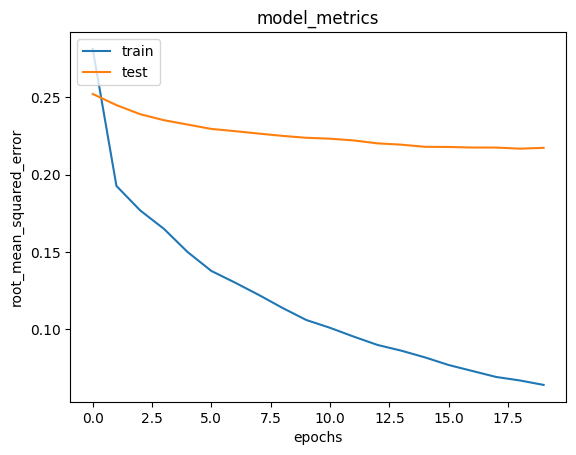

RMSE (Training): 0.06415753811597824
RMSE (Validation): 0.21722540259361267
MAE (Training): 0.0455009825527668
MAE (Validation): 0.17216378450393677


In [104]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
rmse_train = history.history['root_mean_squared_error'][-1]  # Nilai RMSE untuk data pelatihan
rmse_val = history.history['val_root_mean_squared_error'][-1]  # Nilai RMSE untuk data validasi

print(f'RMSE (Training): {rmse_train}')
print(f'RMSE (Validation): {rmse_val}')

# Jika Anda juga memiliki MAE, Anda bisa mencetaknya dengan cara yang sama
mae_train = history.history['mean_absolute_error'][-1]  # Nilai MAE untuk data pelatihan
mae_val = history.history['val_mean_absolute_error'][-1]  # Nilai MAE untuk data validasi

print(f'MAE (Training): {mae_train}')
print(f'MAE (Validation): {mae_val}')

## Mendapatkan Rekomendasi

In [105]:
book_dataset =  book
rating_dataset = rating_dataset[rating_dataset['book_rating'] > 5]

In [106]:
# Mengambil sample user
user_id = rating_dataset.user_id.sample(8).iloc[0]
books_have_been_read_by_user = rating_dataset[rating_dataset.user_id == user_id]
 
books_have_not_been_read_by_user = book_dataset[~book_dataset['book_ISBN'].isin(books_have_been_read_by_user.ISBN.values)]['book_ISBN'] 
books_have_not_been_read_by_user = list(
    set(books_have_not_been_read_by_user).intersection(set(book_to_book_encoded.keys()))
)
 
books_have_not_been_read_by_user = [[book_to_book_encoded.get(x)] for x in books_have_not_been_read_by_user]
user_encoder = user_to_user_encoded.get(user_id)
user_book_array = np.hstack(
    ([[user_encoder]] * len(books_have_not_been_read_by_user), books_have_not_been_read_by_user)
)

In [107]:
ratings = model.predict(user_book_array).flatten()
 
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_book_ids = [
    book_encoded_to_book.get(books_have_not_been_read_by_user[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('Author with high ratings from user')
print('===' * 8) 

top_books_recommended = (
    books_have_been_read_by_user.sort_values(
        by = 'book_rating',
        ascending=False
    )
    .head(5)
    .ISBN.values
)
 
books_row = book_dataset[book_dataset['book_ISBN'].isin(top_books_recommended)]
for row in books_row.itertuples():
    print(row.book_author, ':', row.book_title)
 
print('----' * 8)
print('Top 10 Book Recommendation for user: {}'.format(user_id))
print('----' * 8)
 
recommended_books = book_dataset[book_dataset['book_ISBN'].isin(recommended_book_ids)].drop_duplicates()
#for row in recommended_books.itertuples():
#    print(row.book_author, ':', row.book_title)
for index, row in enumerate(recommended_books.itertuples(), start=1):
    print(f"{index}. {row.book_author} : {row.book_title}")

128/128 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step
Showing recommendations for users: 278450
Author with high ratings from user
--------------------------------
Top 10 Book Recommendation for user: 278450
--------------------------------
1. Harper Lee : To Kill a Mockingbird
2. Robert T. Kiyosaki : Rich Dad, Poor Dad: What the Rich Teach Their Kids About Money--That the Poor and Middle Class Do Not!
3. Carl Sagan : The Demon-Haunted World: Science As a Candle in the Dark
4. Chitra Banerjee Divakaruni : Arranged Marriage: Stories
5. Chitra Banerjee Divakaruni : The Unknown Errors of Our Lives: Stories
6. George Orwell : 1984
7. Jacqueline Carey : Kushiel's Chosen (Kushiel's Legacy)
8. JOHN GRISHAM : The Runaway Jury
9. Anne Bishop : Daughter of the Blood (Black Jewels Trilogy)
10. Anne Rice : Memnoch the Devil (Vampire Chronicles, No 5)
